In [1]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
h = nc.Dataset('sif_env/S5P_OFFL_L1C_SIFTRS_20240206T123417_20240206T123957_32732_93_010100_20250228T104502_irr.nc')
africa = h.groups['africa']
h1 = nc.Dataset('sif_env/S5P_OFFL_L1C_SIFTRS_20240206T105346_20240206T105827_32731_93_010100_20250228T104244_irr.nc')
africa1 = h1.groups['africa']

In [3]:
#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,223]<0.4).all():
            if (africa.variables["Reflectance_err"][0,n,223]<80).all():
                if (africa.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud.append(n)
# scanline_nocloud1 = []
# for n in range(406):
#     if (africa.variables['CloudFraction'][0,n,224]<0.4).all():
#             if (africa.variables["Reflectance_err"][0,n,224]<80).all():
#                 if (africa.variables["SZA"][0,n,224]<75).all():
#                     scanline_nocloud1.append(n)
#remove Reflectance_err>80 and SZA<75

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud1 = []
for n in range(336):
    if (africa1.variables['CloudFraction'][0,n,223]<0.4).all():
            if (africa1.variables["Reflectance_err"][0,n,223]<80).all():
                if (africa1.variables["SZA"][0,n,223]<75).all():
                    if (africa1.variables["SurfaceClassification"][0,n,223] == 148).all():
                        scanline_nocloud1.append(n)
                    

# scanline_nocloud1_ = []
# for n in range(336):
#     if (africa1.variables['CloudFraction'][0,n,224]<0.4).all():
#             if (africa1.variables["Reflectance_err"][0,n,224]<80).all():
#                 if (africa1.variables["SZA"][0,n,224]<75).all():
#                     scanline_nocloud1.append(n)


nocloud_value = np.concatenate((scanline_nocloud, scanline_nocloud1), axis = 0) #scanline_nocloud
nocloud_value.shape

(570,)

In [4]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
        
ds = nc.Dataset("sif_env/wl_per_grpx_sahara_b.nc")
wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
wl_ground_pixel_224 = wl_per_gp_sahara_b[223, :]  # select ground pixel 224 (index 223:224)
wl = wl_ground_pixel_224 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 194))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

ref_na1 = africa1.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo1 = np.zeros((len(scanline_nocloud1), 194))
for idx, i in enumerate(scanline_nocloud1):
    poly_sa = po.polyfit (wl[ind_na], ref_na1[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo1[idx, :] = surf_alb

# ds = nc.Dataset("sif_env/wl_per_grpx_sahara_b.nc")
# wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
# wl_ground_pixel_224 = wl_per_gp_sahara_b[224, :]  # select ground pixel 224 (index 223:224)
# wl = wl_ground_pixel_224 
# retrievalWindow = (734, 758) # retrieval wavelength window [nm]
# windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
# sb_order = 5 # order of polynomial fit of surface reflectivity (barren)
# ind    = indexate(wl, retrievalWindow)
# ind_na = indexate(wl, windowsOfNoAbsorption)
# ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

# #for each scanline model the albedo with the noabsobtion window of reflectance
# surf_albedo1 = np.zeros((len(scanline_nocloud1), 194))
# for idx, i in enumerate(scanline_nocloud1):
#     poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
#     surf_alb = po.polyval (wl[ind], poly_sa)
#     surf_albedo1[idx, :] = surf_alb
# ref_na1 = africa1.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

# #for each scanline model the albedo with the noabsobtion window of reflectance
# surf_albedo1_ = np.zeros((len(scanline_nocloud1_), 194))
# for idx, i in enumerate(scanline_nocloud1):
#     poly_sa = po.polyfit (wl[ind_na], ref_na1[i], sb_order)
#     surf_alb = po.polyval (wl[ind], poly_sa)
#     surf_albedo1[idx, :] = surf_alb


albedo_value = np.concatenate((surf_albedo, surf_albedo1), axis = 0) #surf_albedo 
albedo_value.shape

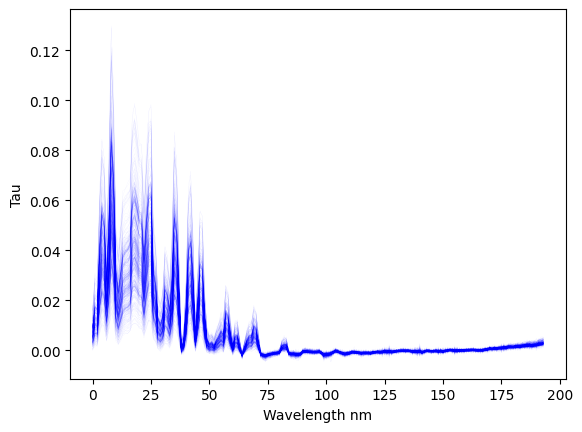

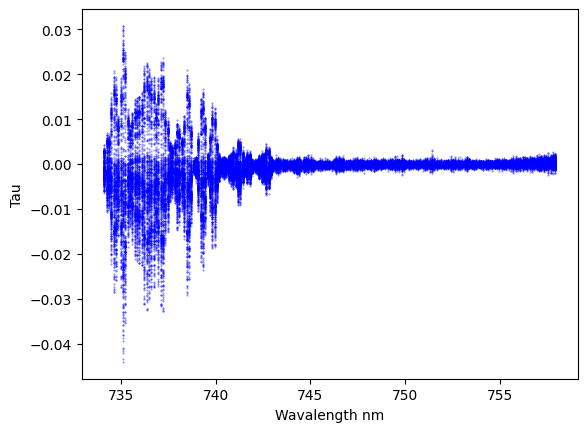

Centered data shape: (570, 194)
Mean after centering: 2.70251657310071e-17


In [5]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
mu_matrix = np.tile(mu[:, np.newaxis], 194)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 194)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data


mu1 = np.cos(np.radians(africa1.variables["VZA"][0,scanline_nocloud1,223]))
mu_01 = np.cos(np.radians(africa1.variables["SZA"][0,scanline_nocloud1,223]))
mu_matrix1 = np.tile(mu1[:, np.newaxis], 194)
mu_0_matrix1 = np.tile(mu_01[:, np.newaxis], 194)
reflectance_matrix1 = africa1.variables['Reflectance'][0, scanline_nocloud1, 223, ind].data

mu_value = np.concatenate((mu_matrix, mu_matrix1), axis = 0) #mu_matrix#
mu_0_value =np.concatenate((mu_0_matrix, mu_0_matrix1), axis = 0)  #mu_0_matrix #
reflectance_value =np.concatenate((reflectance_matrix, reflectance_matrix1), axis = 0) # reflectance_matrix #
angle_value = (mu_value + mu_0_value)/mu_value*mu_0_value
tau_value =  -np.log(reflectance_value/albedo_value)/angle_value #-np.log(reflectance_matrix/surf_albedo)/((mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix)#


for idx, i  in enumerate(nocloud_value):
    plt.plot(tau_value[idx],color='blue', alpha=0.1, linewidth=0.1)
    plt.xlabel("Wavelength nm")
    plt.ylabel("Tau")
plt.show()


# Center data
mean_spectrum = np.mean(tau_value, axis=0)
tau_centered = tau_value - mean_spectrum
for idx, i  in enumerate(scanline_nocloud):
    plt.scatter(wl[ind], tau_centered[idx],color='blue', alpha = 0.5, s= 0.2)
    plt.xlabel('Wavalength nm')
    plt.ylabel('Tau')
    #what is the unit?? 
plt.show()

# Verify
print("Centered data shape:", tau_centered.shape)
print("Mean after centering:", np.mean(tau_centered, axis=0).max())  # Should be ~0

In [24]:
# transminatance = reflectance_value/albedo_value
#I want a plot a 406 by 448 of SIF values 
correct_scanline_nocloud = []
for m in range(448):
    for n in range(406):
        if (africa.variables['CloudFraction'][0,n,m]<0.4).all():
                if (africa.variables["Reflectance_err"][0,n,m]<80).all():
                    if (africa.variables["SZA"][0,n,m]<75).all():
                        scanline_nocloud.append(n)

albedo_matrix = []
for m in range(448):
    ds = nc.Dataset("sif_env/wl_per_grpx_sahara_b.nc")
    wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
    wl_ground_pixel_224 = wl_per_gp_sahara_b[m, :]  # select ground pixel 224 (index 223:224)
    wl = wl_ground_pixel_224 
    retrievalWindow = (734, 758) # retrieval wavelength window [nm]
    windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
    sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
    ind    = indexate(wl, retrievalWindow)
    ind_na = indexate(wl, windowsOfNoAbsorption)
    ref_na = africa.variables["Reflectance"][0, :, m, ind_na].data.tolist()
    
    #for each scanline model the albedo with the noabsobtion window of reflectance
    surf_albedo = np.zeros((len(scanline_nocloud), 194))
    for idx, i in enumerate(scanline_nocloud):
        poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
        surf_alb = po.polyval (wl[ind], poly_sa)
        surf_albedo[idx, :] = surf_alb

    albedo_matrix.append(surf_albedo)

mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
mu_matrix = np.tile(mu[:, np.newaxis], 194)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 194)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data
tau_value =  -np.log(reflectance_matrix/surf_albedo)/((mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix)


transmitance_matrix = reflectance_matrix/surf_albedo
up_transmitance_matrix = np.exp(-tau*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))
irradiance_matrix = np.tile(irradiance_value.T, (406, 1))
# #this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
diff = reflectance_matrix - surf_albedo*transmitance_matrix
I = irradiance_matrix*mu_0_matrix*(np.round(diff, decimals=12))/(up_transmitance_matrix*math.pi) #this I is really I/E_0 
# plt.plot(wl[ind],I.mean(axis=0))
# plt.xlabel('Wavelength')
# plt.ylabel("$I_{SIF}/E_0$")
# #plt.savefig("SIF")
# plt.show()

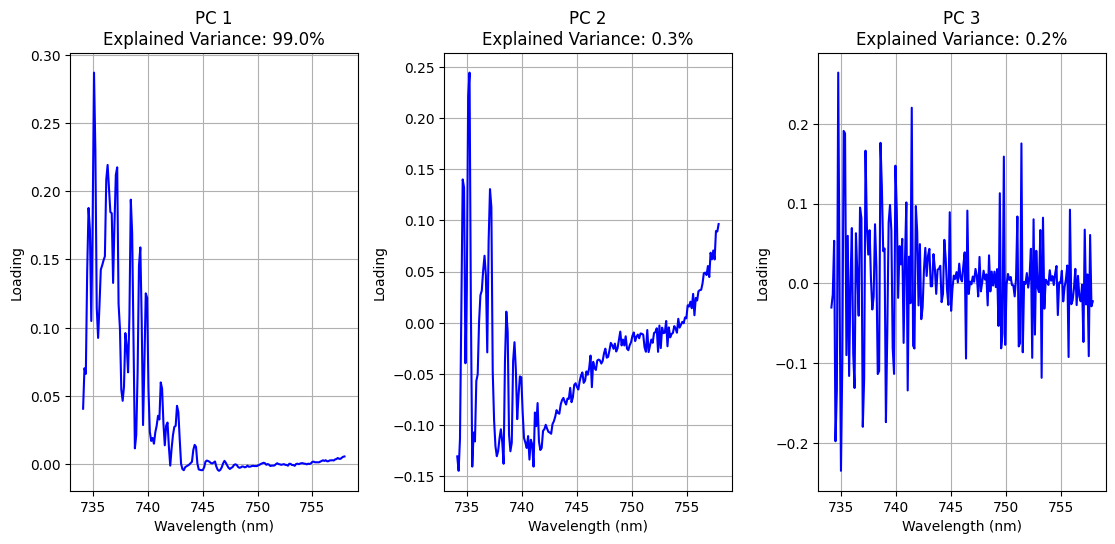

Explained variance by 10 PCs: 99.63%


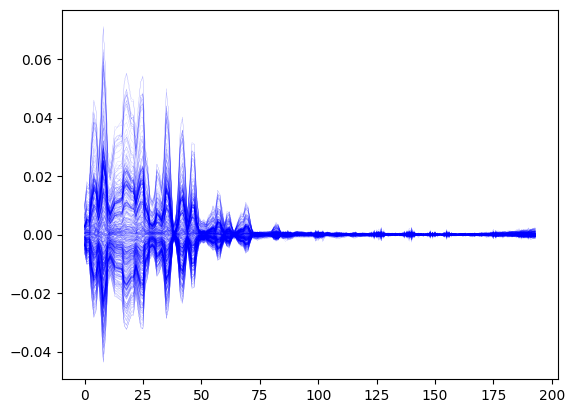

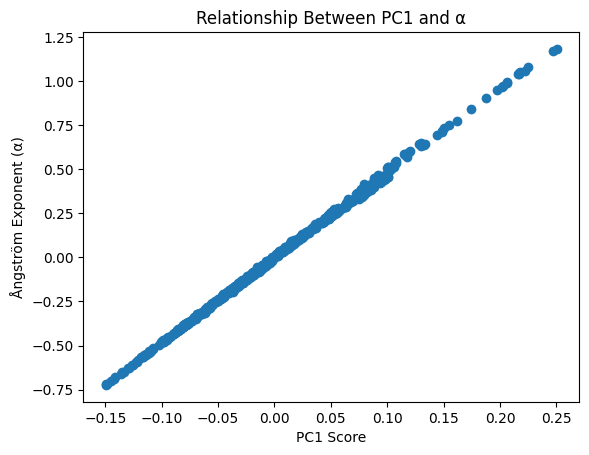

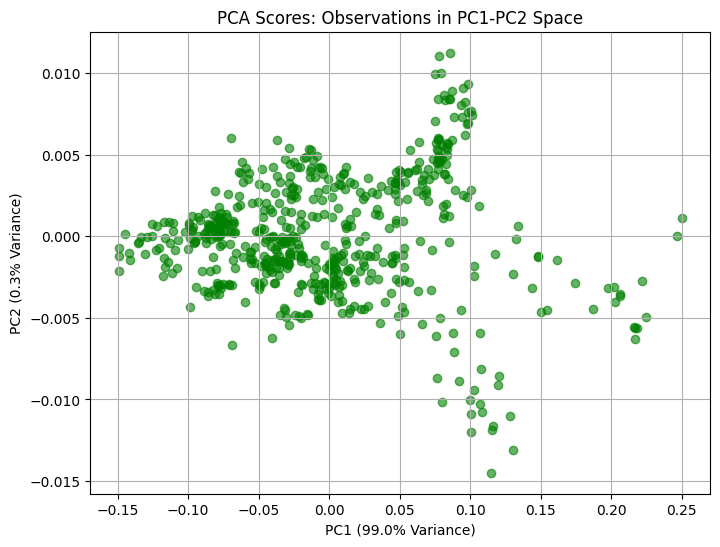

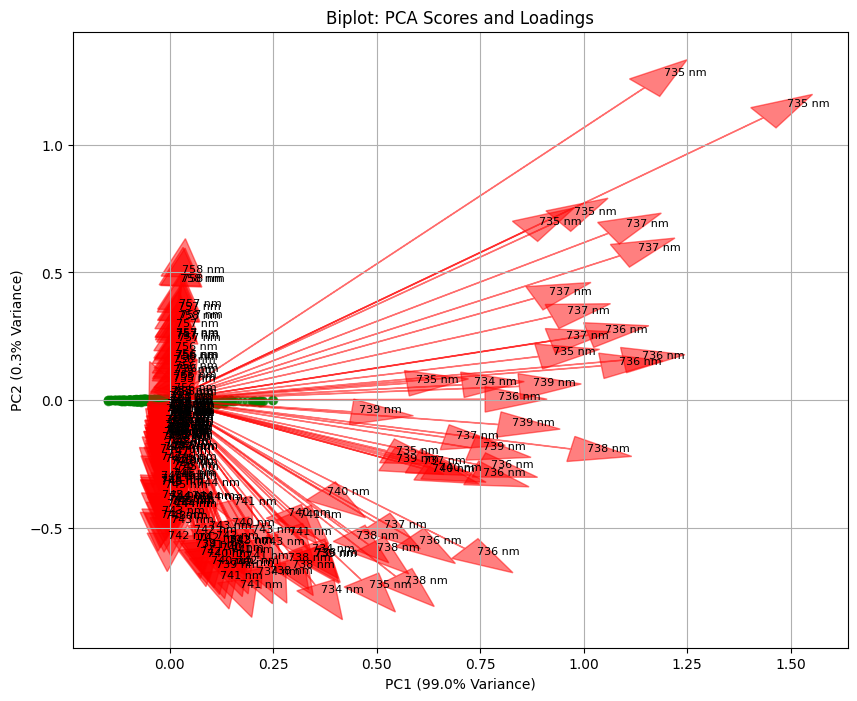

In [6]:
from sklearn.decomposition import PCA
from scipy.stats import linregress
pca = PCA(n_components=15).fit(tau_centered)
components = pca.components_

plt.figure(figsize=(15, 20))
for i in range(3):
    plt.subplot(4, 4, i+1)  # 4x4 grid
    plt.plot(wl[ind], components[i], color='blue')
    plt.title(f'PC {i+1}\nExplained Variance: {pca.explained_variance_ratio_[i]*100:.1f}%')
    plt.xlabel("Feature Index" if wl[ind] is None else "Wavelength (nm)")
    plt.ylabel("Loading")
    plt.grid(True)
plt.tight_layout()
plt.savefig("PCA_tau")
plt.show()

print(f"Explained variance by 10 PCs: {np.sum(pca.explained_variance_ratio_):.2%}")

tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)
tau_reconstructed = pca.inverse_transform(tau_pca)  # Shape: (317, 195)
plt.plot(tau_reconstructed.T,color='blue', alpha = 0.5, linewidth = 0.1)
plt.show()

# Use PC1 scores (most dominant component) as a predictor
pc1_scores = tau_pca[:, 0]

# Fit τ = β ⋅ λ^(-α) using PC1 as a proxy for wavelength dependence
log_w = np.log(wl[ind])
log_tau = np.log(tau_centered + 1)  # Avoid log(0)

# Fit regression for each observation (317 total)
alpha_values = []
beta_values = []
for i in range(tau_value.shape[0]):
    slope, intercept, _, _, _ = linregress(log_w, log_tau[i])
    alpha_values.append(-slope)
    beta_values.append(np.exp(intercept))

# Compare α with PC1 scores (dominant variability)
plt.scatter(pc1_scores, alpha_values)
plt.xlabel('PC1 Score')
plt.ylabel('Ångström Exponent (α)')
plt.title('Relationship Between PC1 and α')
plt.show()

# Project data to PCA space
tau_pca = pca.transform(tau_centered)  # Shape: (317, 10)

# Scatter plot of scores for PC1 vs. PC2
plt.figure(figsize=(8, 6))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('PCA Scores: Observations in PC1-PC2 Space')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(tau_pca[:, 0], tau_pca[:, 1], alpha=0.6, c='green', label='Observations')

# Plot eigenvectors as arrows
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*5, y*5, color='red', alpha=0.5, head_width=0.1)
    plt.text(x*5.2, y*5.2, f'{wl[ind][i]:.0f} nm', color='black', fontsize=8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.title('Biplot: PCA Scores and Loadings')
plt.grid(True)
plt.show()

In [56]:
##SIF-retrieval 

In [7]:
#SOLAR IRRADIANCE -- The same in all areas of the world 
irradiance_vector = africa.variables["irradiance"][223, ind]
#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
    """
    Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ (photon flux) to mW m⁻² nm⁻¹.

    Parameters:
        irradiance_mol (array-like): Irradiance in mol s⁻¹ m⁻² nm⁻¹
        wavelength_nm (array-like): Corresponding wavelengths in nm

    Returns:
        array: Irradiance in mW m⁻² nm⁻¹
    """
    # Constants
    h = 6.62607015e-34  # Planck constant (J·s)
    c = 2.99792458e8    # Speed of light (m/s)
    Na = 6.02214076e23  # Avogadro's number (photons/mol)

    wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to m
    photon_energy = h * c / wavelength_m           # Energy per photon (J)

    irradiance_watts = np.array(irradiance_mol) * Na * photon_energy  # W m⁻² nm⁻¹
    irradiance_mW = irradiance_watts * 1e3  # Convert W to mW

    return irradiance_mW
       
irradiance_value = convert_irradiance(irradiance_vector, wl[ind])

In [8]:
len(wl[ind])

194

(15, 194)
Fitted parameters:
[ 7.36764663e+01 -3.01838341e-01  4.14336734e-04 -1.89167298e-07
  1.62528503e-01  9.21918202e-03 -1.31060743e-03 -1.24803700e-03
 -1.65473166e-03  1.43241397e-03 -3.10419842e-04 -7.60329753e-04
  1.16108517e-03  1.96254099e-04  5.94962995e-04 -9.79096831e-05
  5.18150222e-04 -1.74387190e-04 -4.85503245e-04  2.99812582e-02]


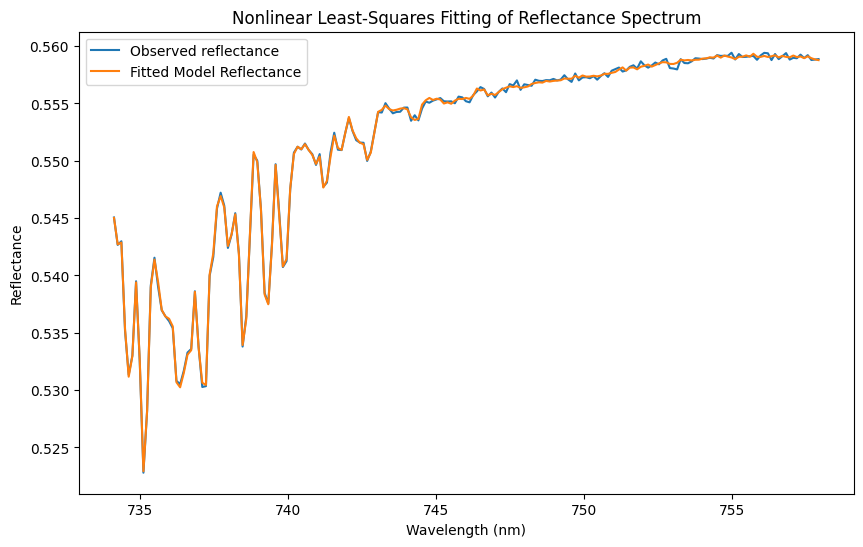

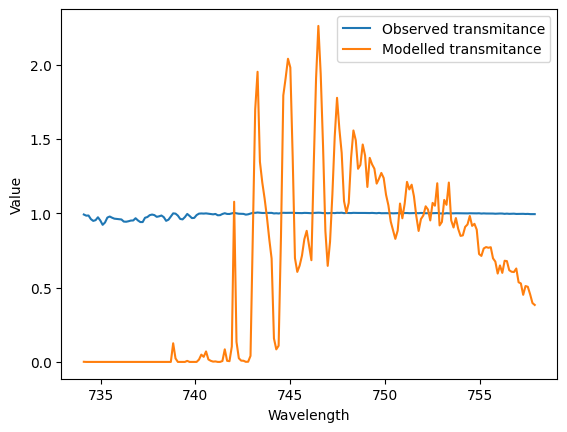

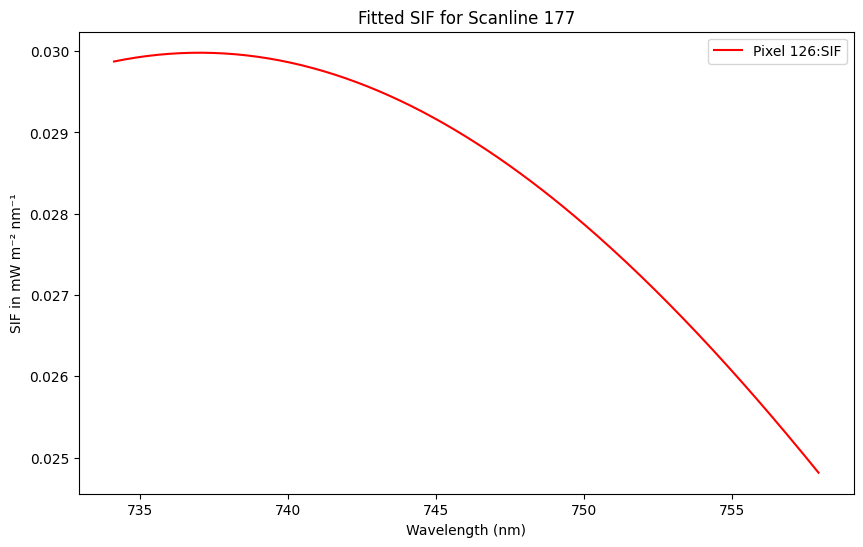

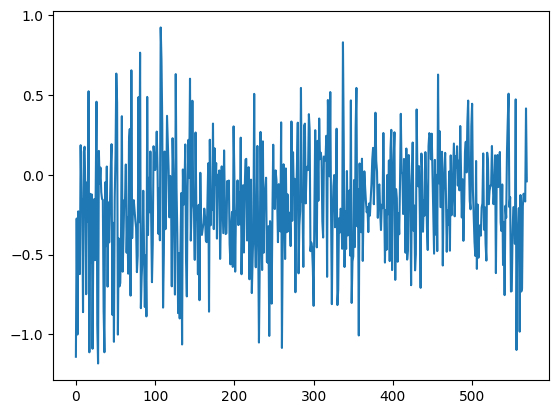

In [21]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
m = 4
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])

    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        #plt.savefig("ML_fit_mean_SIF")
        plt.show()
plt.plot(SIF_values_per_scanline)
plt.show() 

In [22]:
np.mean(SIF_values_per_scanline)

np.float64(-0.18364380984476908)

(15, 194)
Fitted parameters:
[ 1.57523580e-01  1.58247011e-02 -2.27781809e-03 -5.85852680e-03
  9.87403406e-04  1.39986251e-03  2.61635742e-05 -3.40967972e-04
  1.39500813e-03 -2.96385368e-04  8.89192866e-04 -3.60926570e-04
  6.83650234e-04  1.01195828e-04 -4.03614000e-04  8.27626258e-03]


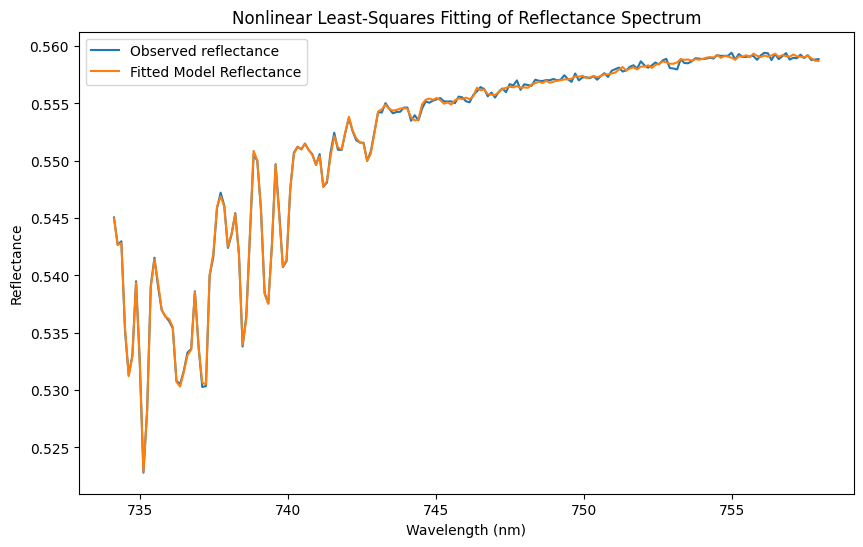

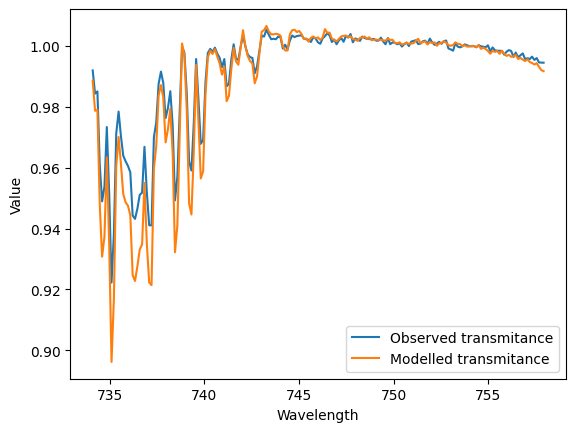

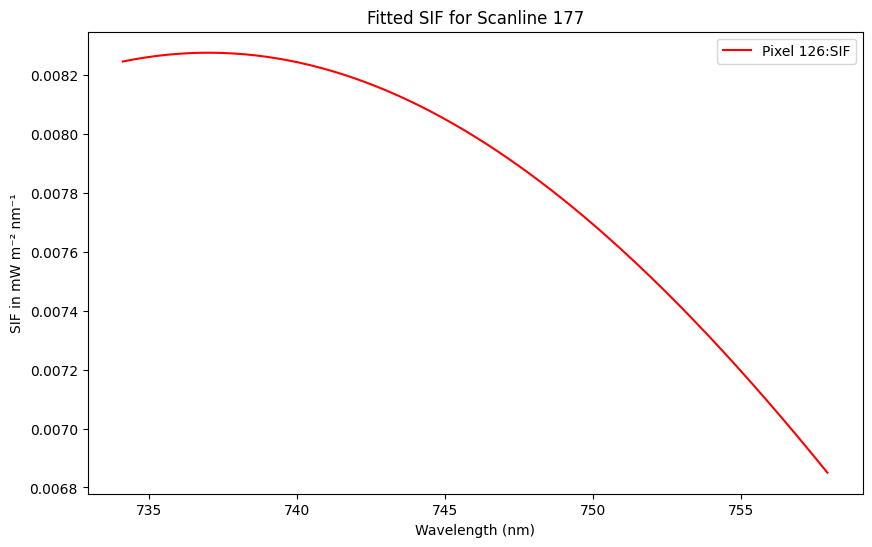

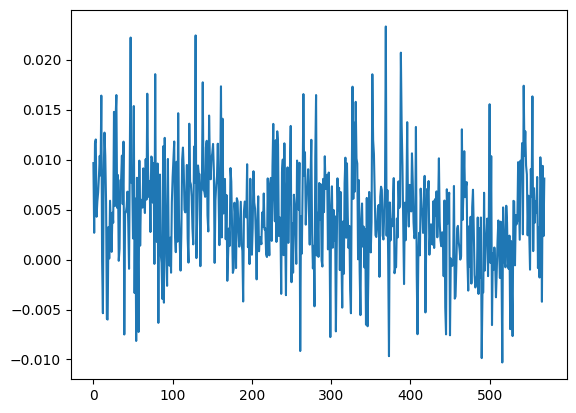

In [12]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = albedo_value[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5] * n + [0.5]
    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_value[100]) + np.reciprocal(mu_0_value[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("ML_fit_mean_tropomi")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud[100]}:SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for Scanline 177")
        plt.legend()
        #plt.savefig("ML_fit_mean_SIF")
        plt.show()

plt.plot(SIF_values_per_scanline)
plt.show()  

In [13]:
h2 = nc.Dataset('sif_env/S5P_OFFL_L1C_SIFTRS_20240206T172817_20240206T173755_32735_93_010100_20250228T104827_irr.nc')
amazon = h2.groups['amazon']

In [14]:
#Remove clouds
scanline_nocloud2 = []
for n in range(406):
    if (amazon.variables['CloudFraction'][0,n,223]<0.4).all():
            if (amazon.variables["Reflectance_err"][0,n,223]<80).all():
                if (amazon.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#Fixing albedo 

ref_na2 = amazon.variables["Reflectance"][0, scanline_nocloud2, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 194))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb

#Computing tau
mu2 = np.cos(np.radians(amazon.variables["VZA"][0,scanline_nocloud2,223]))
mu_02 = np.cos(np.radians(amazon.variables["SZA"][0,scanline_nocloud2,223]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,194))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 194))
reflectance_matrix2 = amazon.variables['Reflectance'][0, scanline_nocloud2, 223, ind]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))

tau_mean2 = tau2.mean(axis = 0)

(15, 194)
Fitted parameters:
[-7.98300934e+00  2.12897845e-02 -1.37031813e-05  9.00430280e-01
 -4.51944409e-02  7.10264387e-03 -1.70772605e-02  1.45866153e-02
 -1.96398305e-05  5.32768161e-03  7.29000553e-03  1.54827289e-03
  7.84196875e-03 -2.36723049e-03  1.59415778e-03  1.86647031e-03
 -1.81192320e-03 -2.66203994e-03  1.29173818e+00]


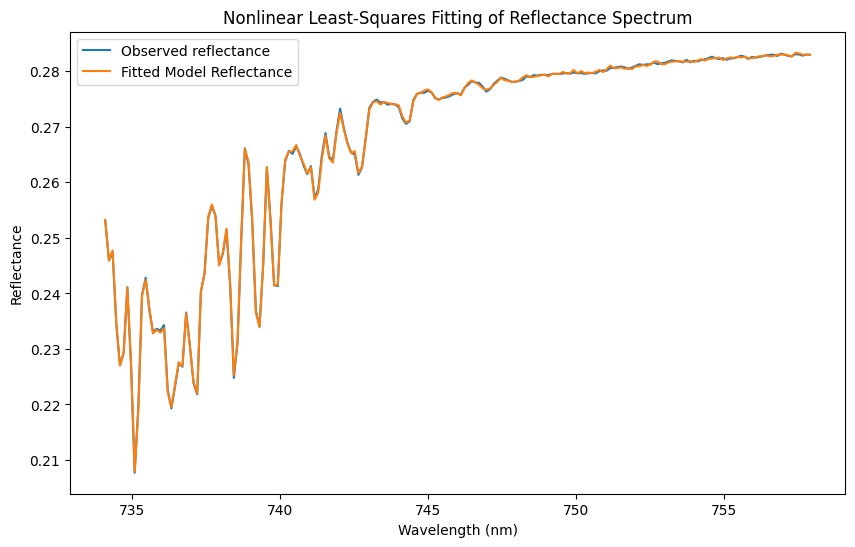

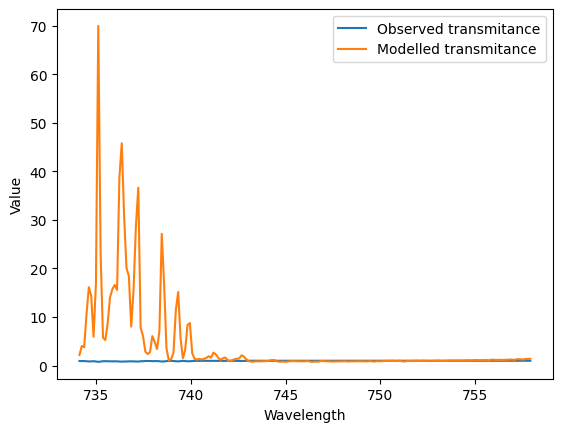

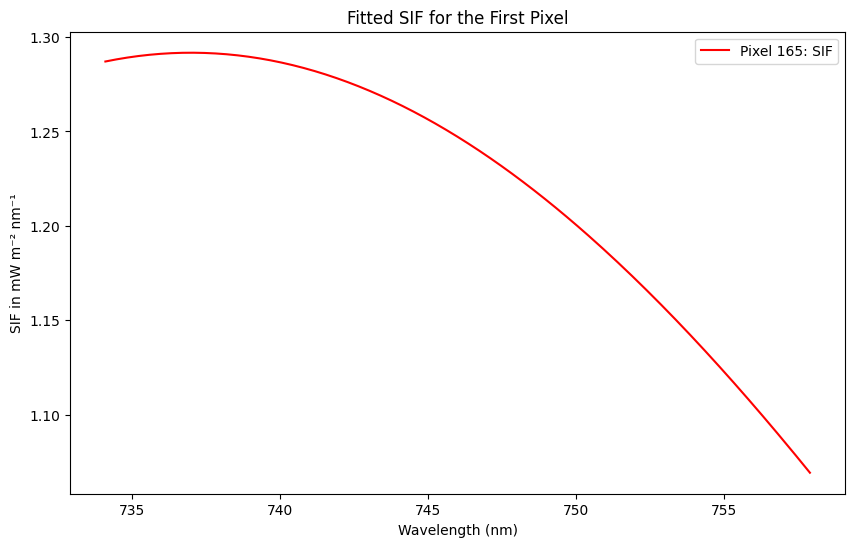

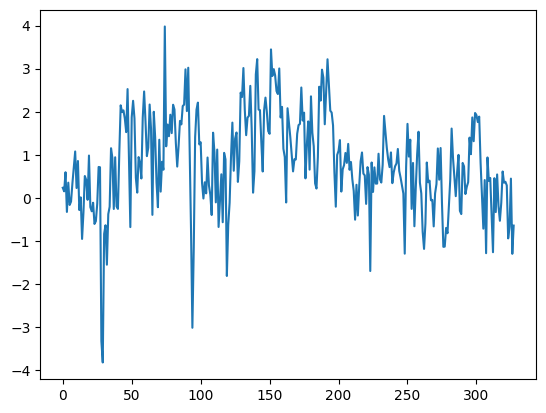

0.8002425591712695


In [19]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    m = 3
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

    SIF_values_per_scanline2.append(popt[-1])
    if pixel_index == 100:
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
        
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_mean_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_mean_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("SIF in mW m⁻² nm⁻¹")
        plt.title("Fitted SIF for the First Pixel")
        plt.legend()
        #plt.savefig("LM_fit_SIF_mean_A")
        plt.show()

plt.plot(SIF_values_per_scanline2)
plt.show()
print(np.mean(SIF_values_per_scanline2))

(15, 194)
Fitted parameters:
[ 8.77912275e-01 -2.89098038e-02  4.86176958e-03 -2.50382092e-02
  1.71803637e-02 -3.17700242e-04  5.67680415e-03  9.01200429e-03
  1.26334344e-03  7.86313005e-03 -2.06670043e-03  1.97995789e-03
  6.97033737e-05 -2.19086420e-03 -2.16975212e-03  3.85356839e-02]


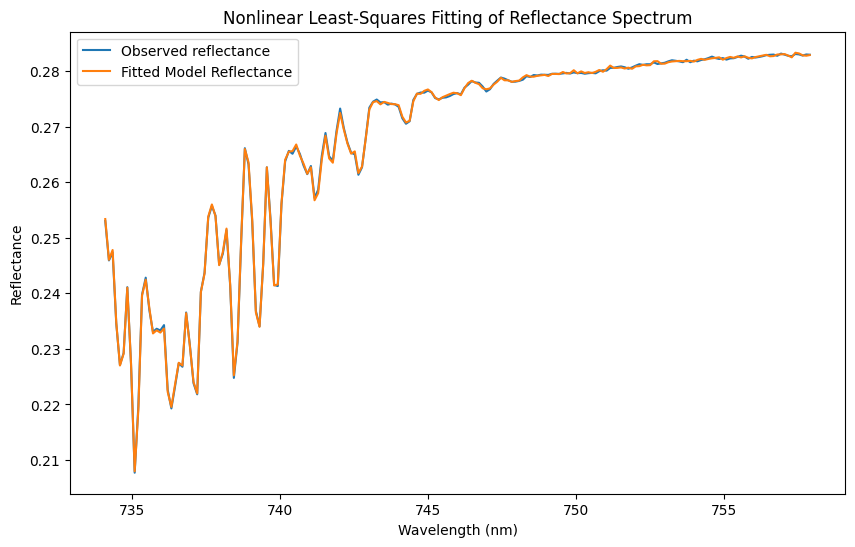

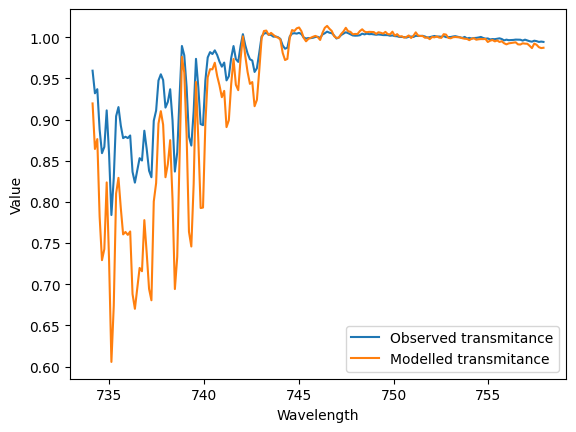

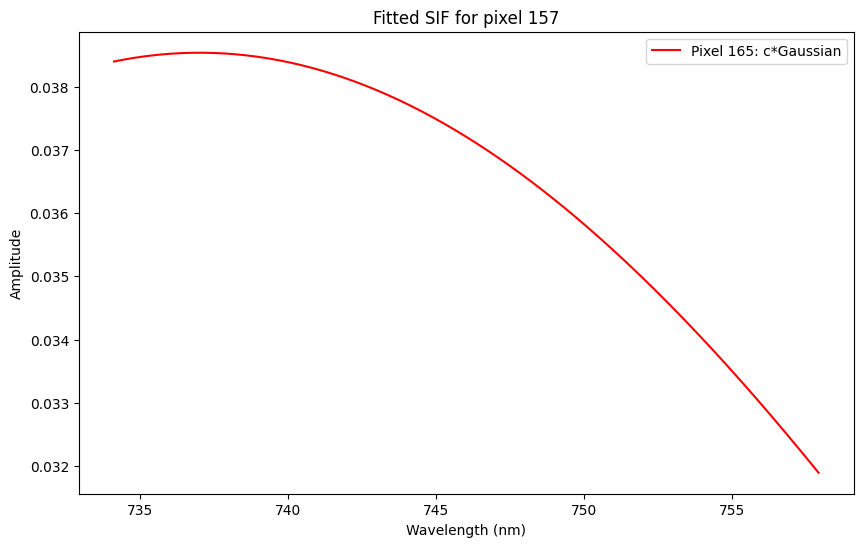

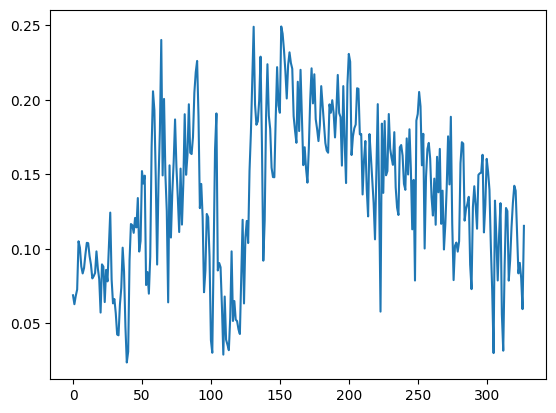

0.1372889421547597


In [16]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0] * n + [0]
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
    SIF_values_per_scanline2.append(popt[-1])
    
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_AE_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_AE_transmitance_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: c*Gaussian", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Amplitude")
        plt.title("Fitted SIF for pixel 157")
        #plt.savefig("LM_fit_SIF_AE_A")
        plt.legend()
        plt.show()
plt.plot(SIF_values_per_scanline2)
plt.show()
print(np.mean(SIF_values_per_scanline2))        
